In [20]:
import cv2

In [25]:
def _generate_frame_differences(video_path):

    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise OSError(f"Could not open video: {video_path}")

    diffs = []
    prev_gray = None
    try:
        while True:
            ok, frame = cap.read()
            if not ok or frame is None:
                break

            if frame.ndim == 3:
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            else:
                gray = frame

            gray = gray.astype(np.float32, copy=False)

            if prev_gray is None:
                diffs.append(0.0)
            else:
                diff_val = np.mean(np.abs(gray - prev_gray))
                diffs.append(float(diff_val))

            prev_gray = gray
    finally:
        cap.release()

    return np.array(diffs, dtype=float)

In [1]:
%reload_ext autoreload
%autoreload 2
import slap2_py as spy
import wisco_slap as wis
import wisco_slap.defs as DEFS
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
import h5py
import glob
import polars as pl
from pathlib import Path
import tifffile
import seaborn as sns
import electro_py as epy
import cv2

In [ ]:
subject = 'avior'
exp = 'exp_2'
sb=1
locs = ['loc_C', 'loc_K']
acq = 'acq_2'

In [ ]:
sd_video_path = f'{DEFS.data_root}/{subject}/{exp}/{subject}--{exp}--SD.mp4'
sdnp = _generate_frame_differences(sd_video_path)
np.save(f'{DEFS.data_root}/{subject}/{exp}/SD-DIFFS.npy', sdnp)

In [5]:
ephys = wis.peri.ephys.load_exp_ephys_data(subject, exp, stores=['EEGr', 'EEG_', 'loal'])

read from t=0s to t=11229.85s
Using 24414.0625 Hz as SEV sampling rate for EEGr
read from t=0s to t=11229.85s
Using 610.3516 Hz as SEV sampling rate for EEG_
read from t=0s to t=11229.85s


In [6]:
eyedf = wis.peri.vid.load_eye_metric_df(subject, exp, sb=sb)
whis = wis.peri.vid.load_whisking_df(subject, exp, sb=sb)

In [10]:
hypno = wis.peri.vig.load_auto_hypno(subject, exp, sb, filter_unclear=0.66)

In [7]:
soma_dfs = []
for loc in locs:
    soma_df = wis.scope.io.load_roidf(subject, exp, loc, acq, apply_ephys_offset=True)
    soma_dfs.append(soma_df)
sdf = pl.concat(soma_dfs)

In [8]:
syndfs = []
for loc in locs:
    syndf = wis.scope.io.load_syndf(subject, exp, loc, acq, trace_types=['matchFilt'], apply_ephys_offset=True)
    syndfs.append(syndf)
syndf = pl.concat(syndfs)

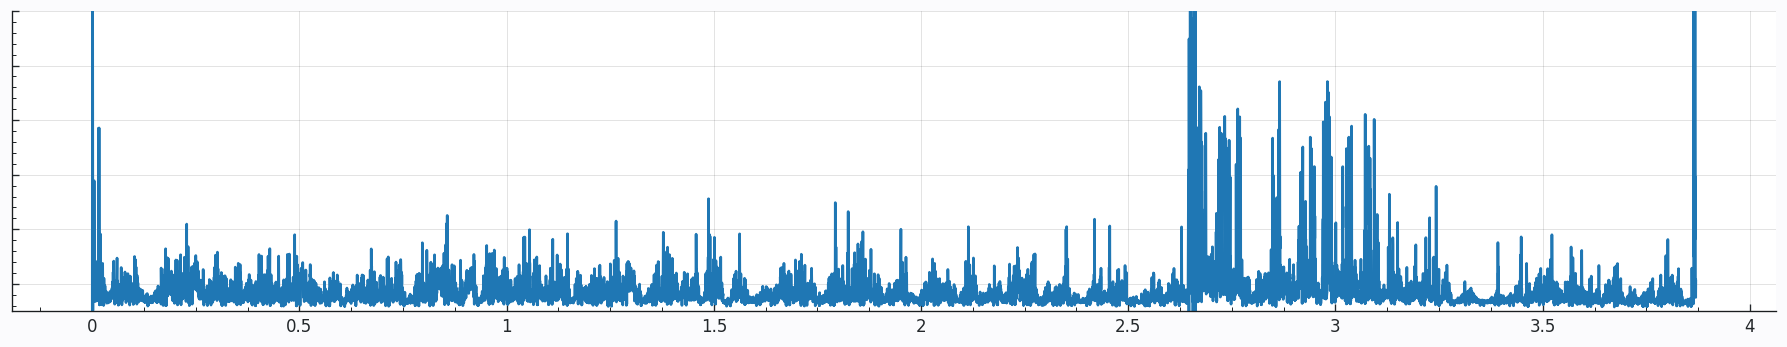

In [48]:
spy.plot.slap_style(version='fig')
f, ax = plt.subplots(1, 1, figsize=(15, 3), sharex=True)
ax.plot(sdnp[::30])
ax.set_ylim(2.5, 8)
ax.set_xticks([0, 0.18e4, 0.36e4, 0.54e4, 0.72e4, 0.9e4, 1.08e4, 1.26e4, 1.44e4])
ax.set_xticklabels([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
ax.set_yticklabels([])
plt.tight_layout()
plt.savefig(f"{DEFS.plots_root}/{subject}-{exp}--SD-DIFFS.svg", transparent=True, bbox_inches='tight')

In [9]:
sdf = sdf.sort('time', descending=False)
syndf = syndf.sort('time', descending=False)

In [65]:
d = ephys['EEG_'].data[::6]
t = ephys['EEG_'].time.values[::6]

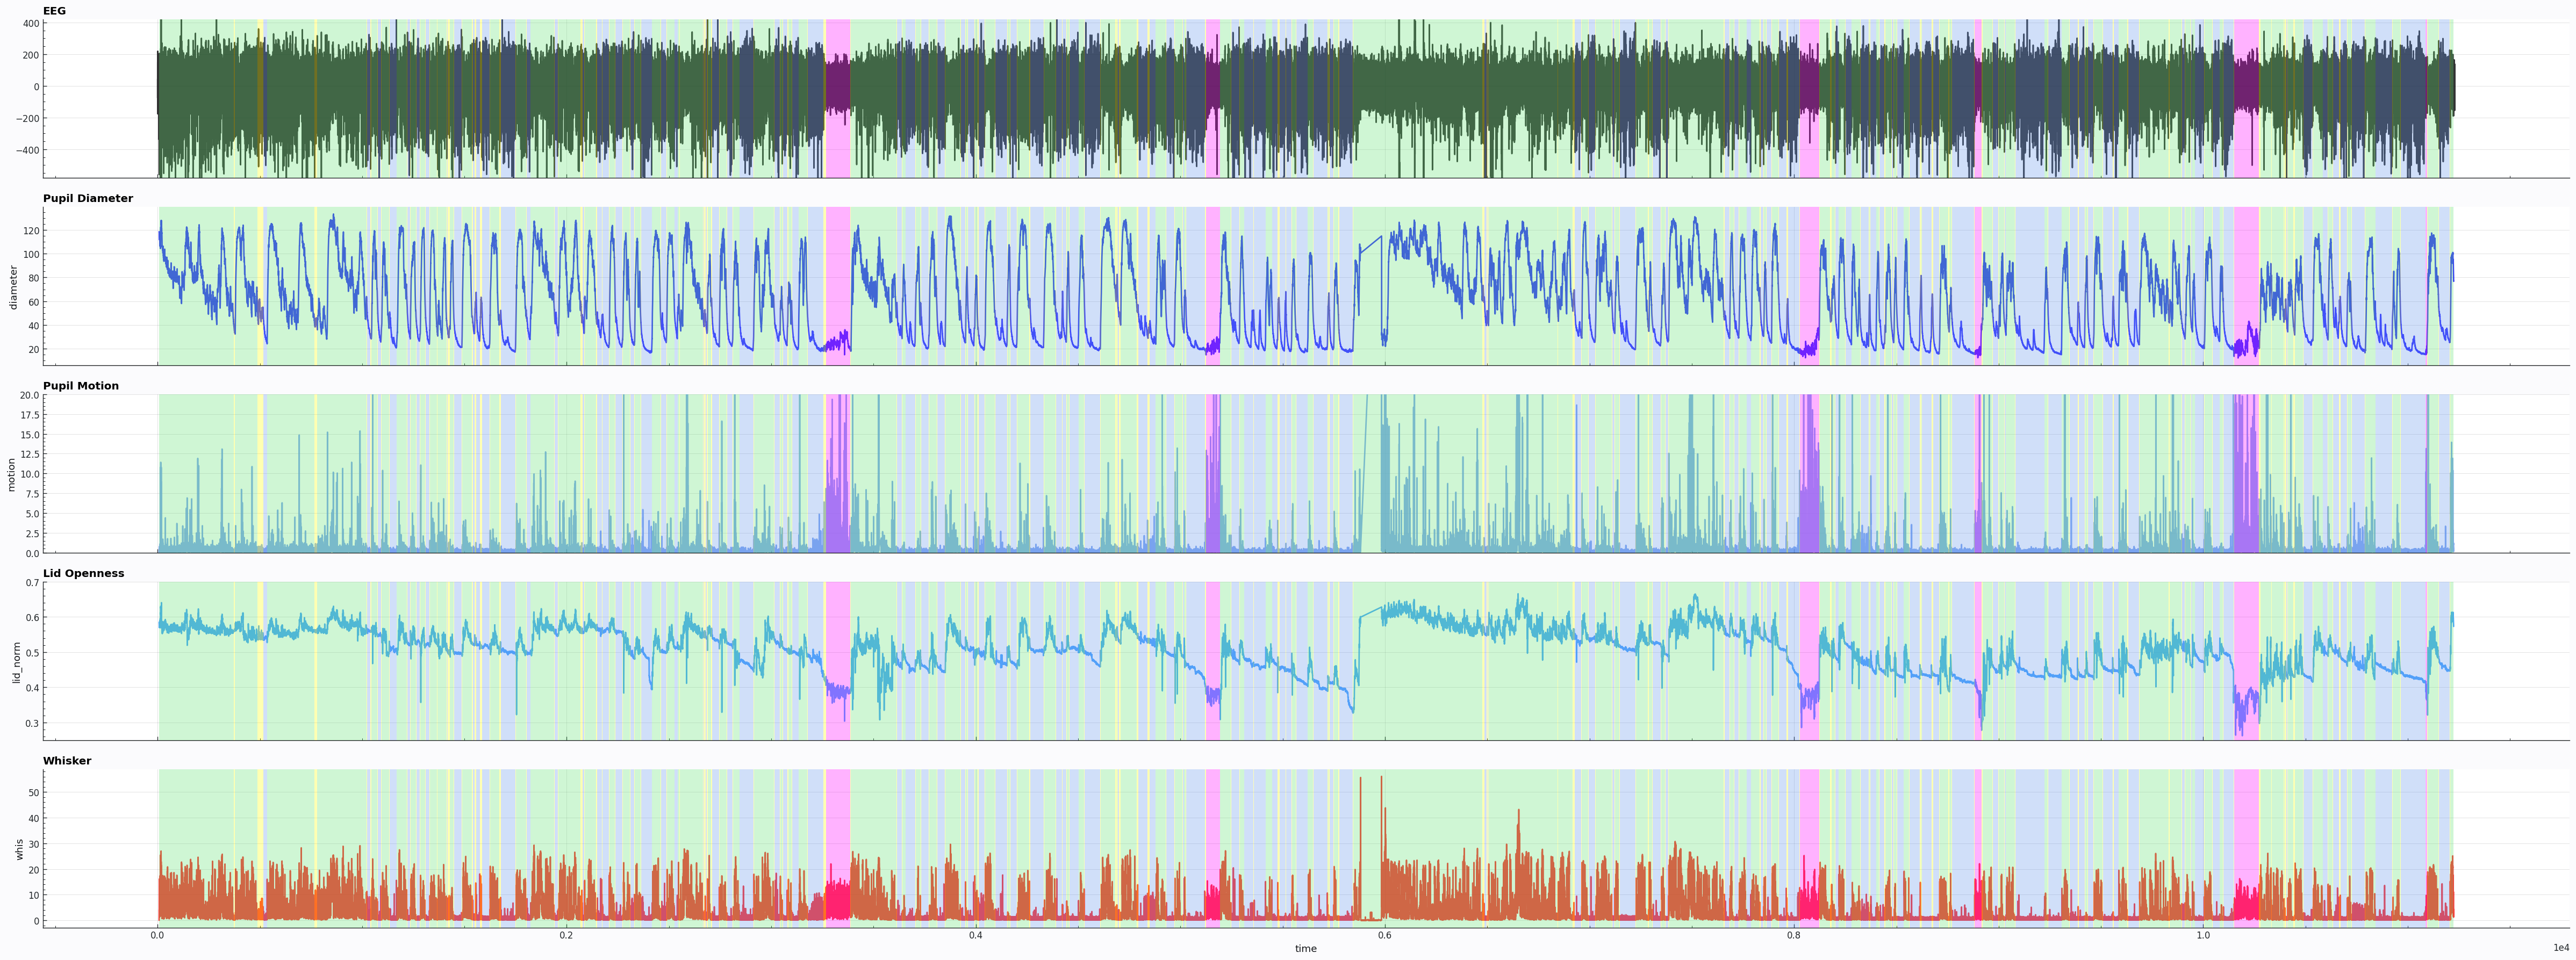

In [106]:
f, ax = plt.subplots(5, 1, figsize=(40, 15), sharex=True)
ax[0].plot(t, d, color='k', alpha=0.8)
ax[0].set_ylim(-580, 420)
ax[0].set_title('EEG')
sns.lineplot(data=eyedf.filter(pl.col('pup_likelihood') > 0.7), x='time', y='diameter', ax=ax[1], color='blue', alpha=0.8)
ax[1].set_title('Pupil Diameter')
sns.lineplot(data=eyedf.filter(pl.col('pup_likelihood') > 0.7), x='time', y='motion', ax=ax[2], color='cornflowerblue', alpha=0.8)
ax[2].set_title('Pupil Motion')
ax[2].set_ylim(0, 20)
sns.lineplot(data=eyedf.filter(pl.col('lid_likelihood') > 0.7), x='time', y='lid_norm', ax=ax[3], color='dodgerblue', alpha=0.8)
ax[3].set_title('Lid Openness')
ax[3].set_ylim(0.25, 0.7)

sns.lineplot(data=whis, x='time', y='whis', ax=ax[4], color='red', alpha=0.8)
ax[4].set_title('Whisker')

for a in ax:
    epy.plot.utils.shade_hypno_for_me(hypno, a, alpha=0.3)
plt.tight_layout()
f.savefig(f"{DEFS.plots_root}/{subject}-{exp}--EEG-eye-whisker.png", transparent=True, bbox_inches='tight', dpi=300)

In [111]:
soma_k = sdf.filter(pl.col('loc') == 'loc_K')

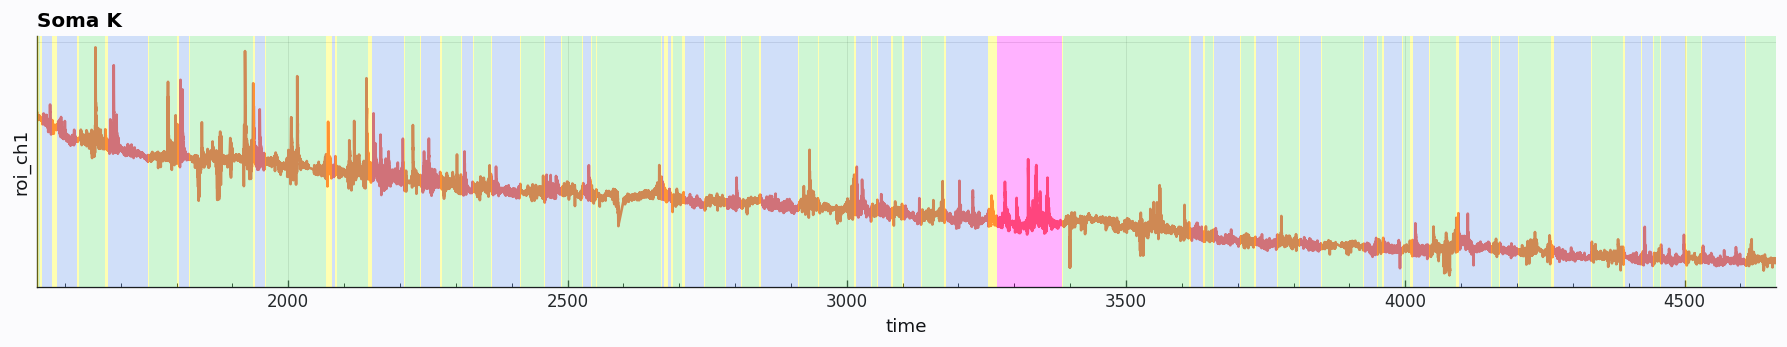

In [137]:
f, ax = plt.subplots(1, 1, figsize=(15, 3))

ax = sns.lineplot(data=soma_k, x='time', y='roi_ch1', ax=ax, color='tomato', alpha=1)
ax.set_yscale('log')
ax.set_title('Soma K')
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
epy.plot.utils.shade_hypno_for_me(hypno, ax, alpha=0.3)
plt.tight_layout()
ax.set_xlim(soma_k['time'].min(), soma_k['time'].max())
plt.savefig(f"{DEFS.plots_root}/{subject}-{exp}--soma-k.png", transparent=True, bbox_inches='tight', dpi=300)


In [128]:
soma_c = sdf.filter(pl.col('loc') == 'loc_C')

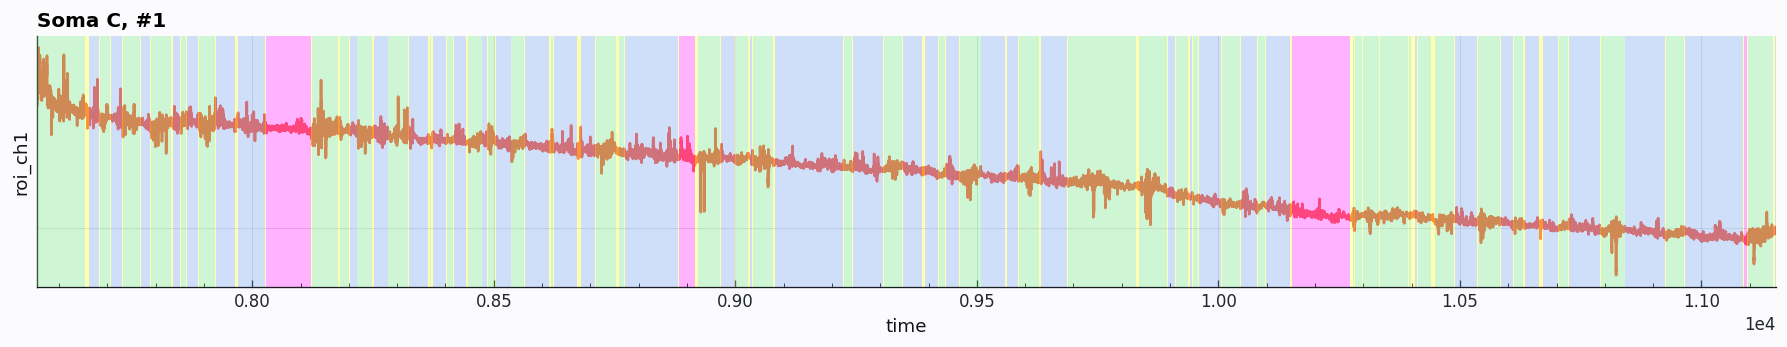

In [138]:
f, ax = plt.subplots(1, 1, figsize=(15, 3))

ax = sns.lineplot(data=soma_c.filter(pl.col('roi_name') == 'soma1'), x='time', y='roi_ch1', ax=ax, color='tomato', alpha=1)
ax.set_yscale('log')
ax.set_title('Soma C, #1')
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
epy.plot.utils.shade_hypno_for_me(hypno, ax, alpha=0.3)
ax.set_xlim(soma_c.filter(pl.col('roi_name') == 'soma1')['time'].min(), soma_c.filter(pl.col('roi_name') == 'soma1')['time'].max())
plt.tight_layout()
plt.savefig(f"{DEFS.plots_root}/{subject}-{exp}--soma-C1.png", transparent=True, bbox_inches='tight', dpi=300)


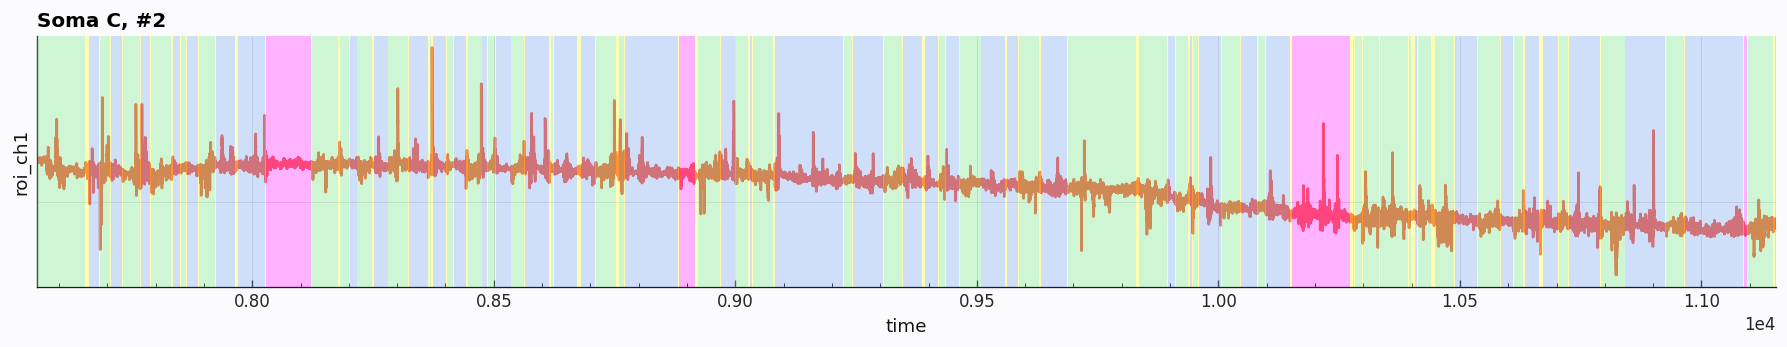

In [139]:
f, ax = plt.subplots(1, 1, figsize=(15, 3))

ax = sns.lineplot(data=soma_c.filter(pl.col('roi_name') == 'soma2'), x='time', y='roi_ch1', ax=ax, color='tomato', alpha=1)
ax.set_yscale('log')
ax.set_title('Soma C, #2')
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
epy.plot.utils.shade_hypno_for_me(hypno, ax, alpha=0.3)
ax.set_xlim(soma_c.filter(pl.col('roi_name') == 'soma2')['time'].min(), soma_c.filter(pl.col('roi_name') == 'soma2')['time'].max())
plt.tight_layout()
plt.savefig(f"{DEFS.plots_root}/{subject}-{exp}--soma-C2.png", transparent=True, bbox_inches='tight', dpi=300)


In [ ]:
mf = syndf.filter(pl.col('trace_type') == 'matchFilt')
syn_c = syndf.filter(pl.col('loc') == 'loc_C')
syn_k = syndf.filter(pl.col('loc') == 'loc_K')

In [14]:
syn_c_quick = syn_c.filter(pl.col('source') < 120).filter(pl.col('time')<8000).filter(pl.col('dmd')==1)

In [15]:
source_dats = []
for source in syn_c_quick['source'].unique():
    source_dats.append(syn_c_quick.filter(pl.col('source') == source)['data'].to_numpy())
source_dats = np.array(source_dats)
source_dats.shape

(104, 89154)

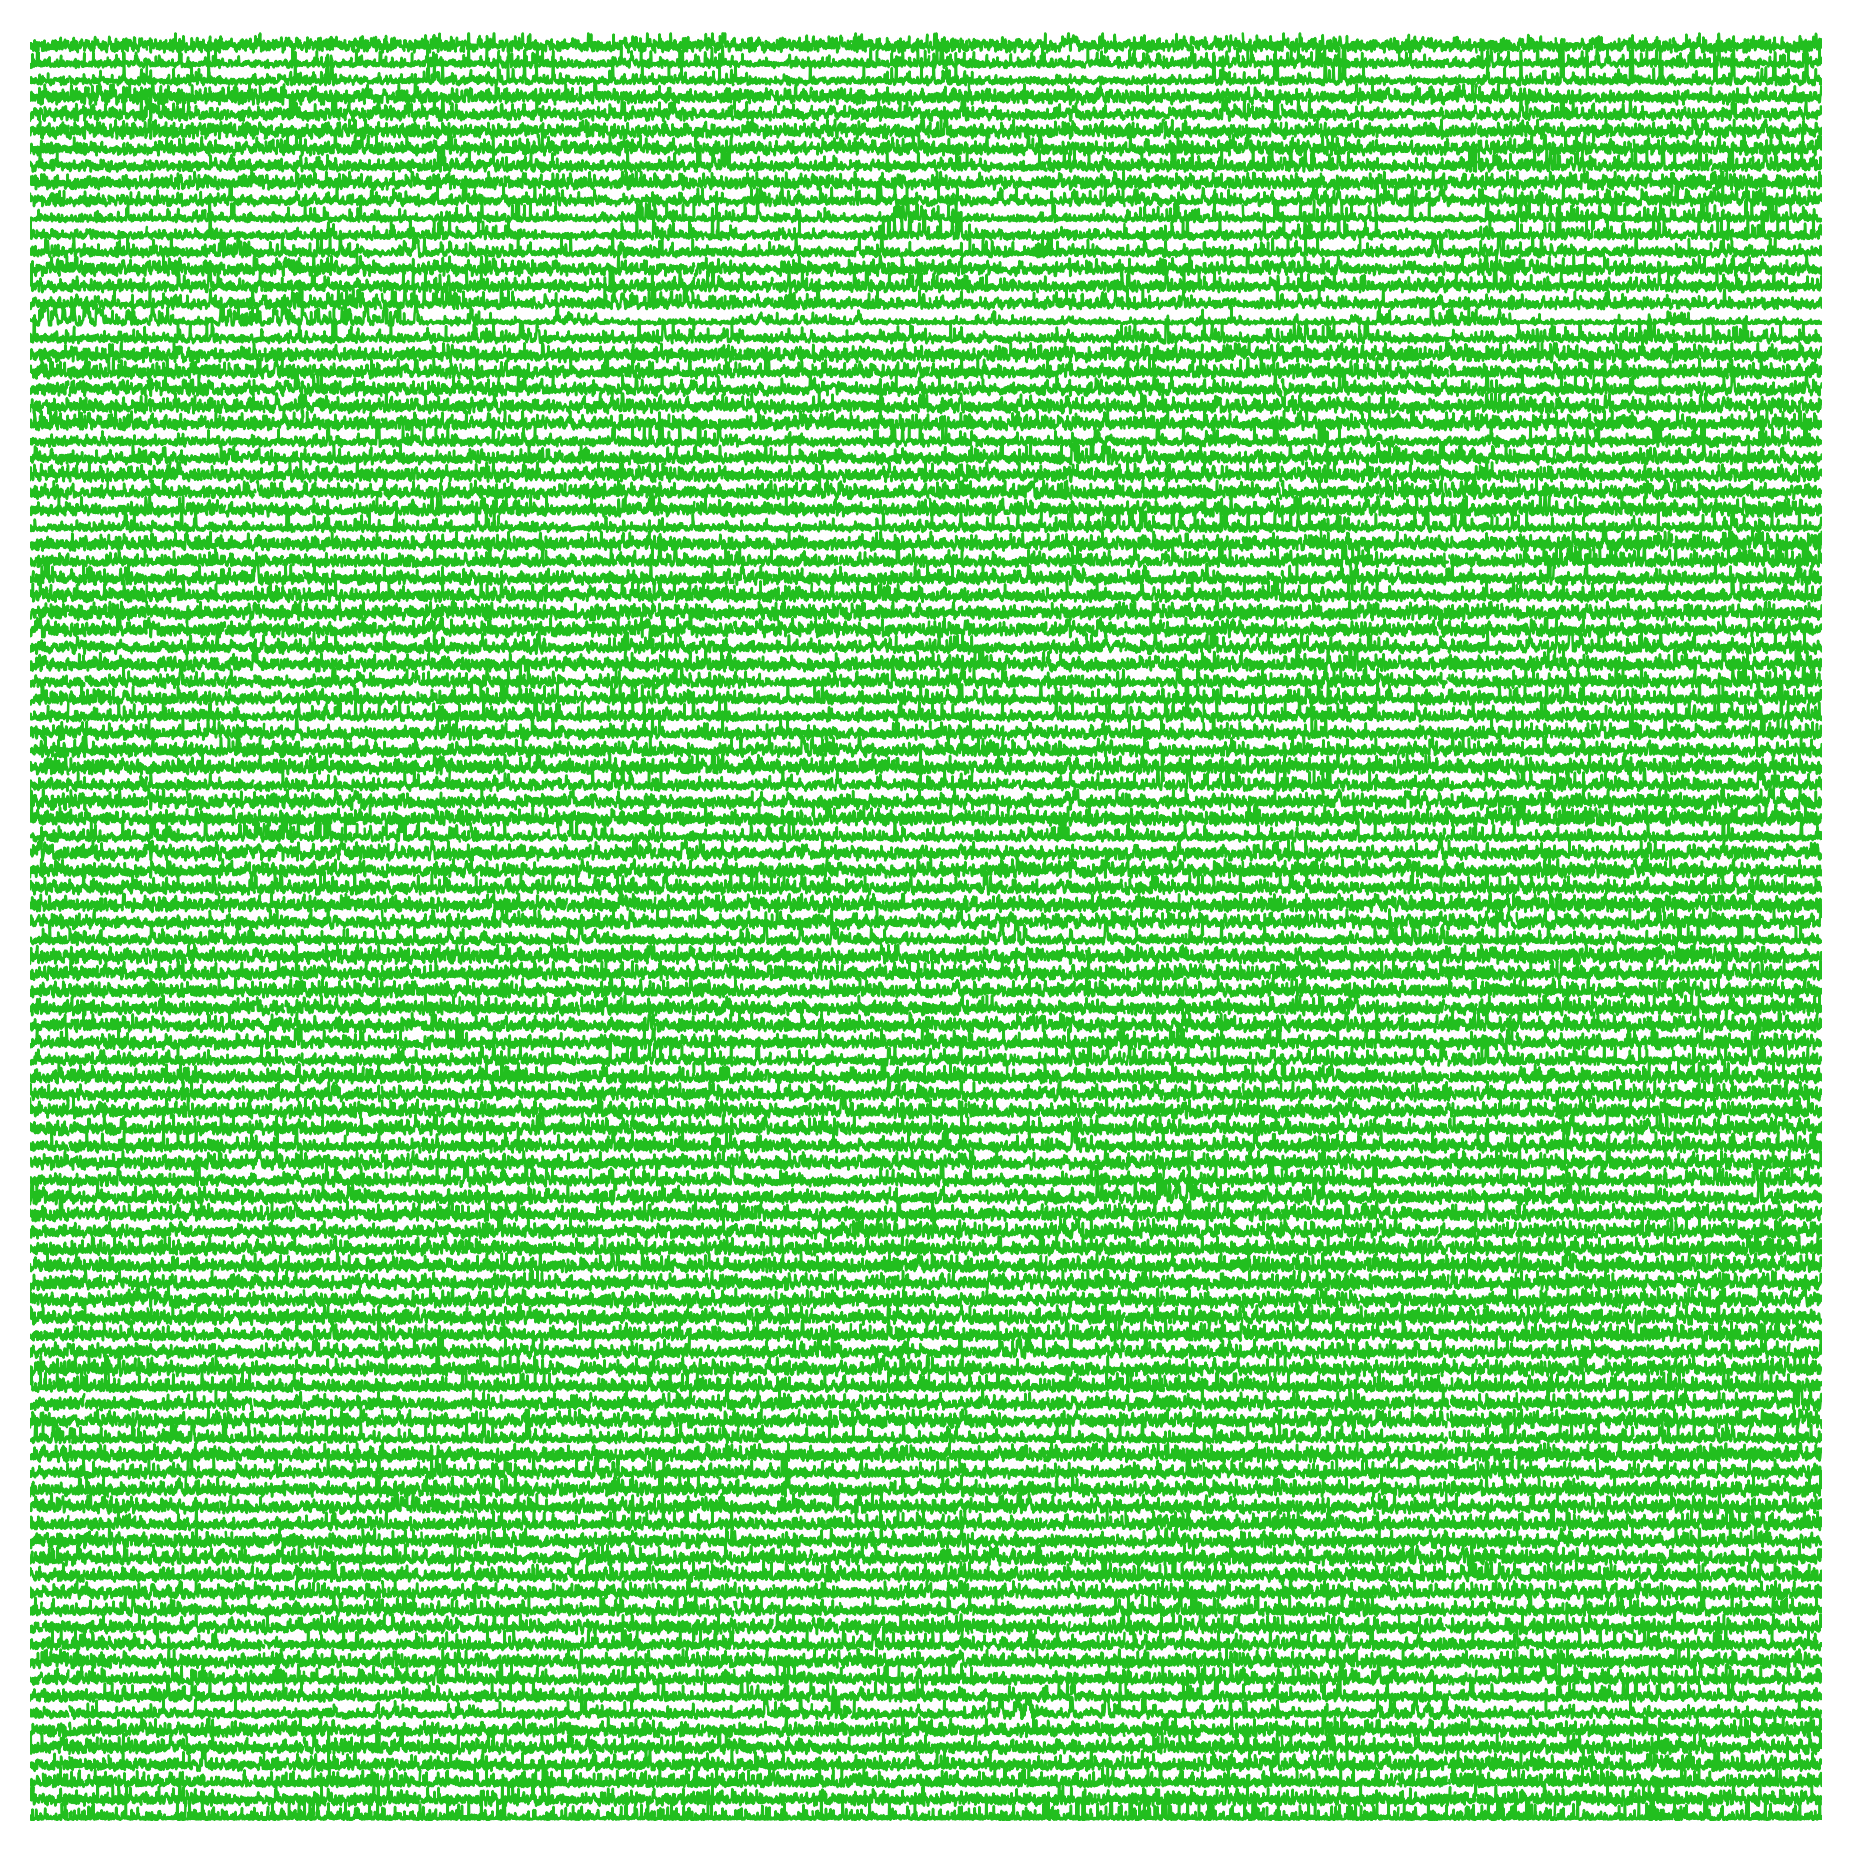

In [16]:
f, ax = spy.plot.main.plot_synaptic_traces(source_dats, 200, normalize='none')

In [26]:
subject = 'kaus'
exp = 'exp_1'
sb=1
locs = ['loc_E']
acq = 'acq_1'

In [27]:
sd_video_path = f'{DEFS.data_root}/{subject}/{exp}/{subject}--{exp}--SD.mp4'
sdnp = _generate_frame_differences(sd_video_path)
np.save(f'{DEFS.data_root}/{subject}/{exp}/SD-DIFFS.npy', sdnp)